## Calculate volume of difference maps in polygon regions


In [1]:
import json
from shapely.geometry import Polygon, Point
from descartes.patch import PolygonPatch
import shapely.vectorized
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
%matplotlib inline

#### Extract coordinates and maps from zipped file
This requires alot of memory

In [2]:
npzf = np.load("sandwich_maps.npz")
npzf.files
X=npzf['X']
Y=npzf['Y']
zmean=npzf['zmean']
zw = npzf['zw']

In [3]:
(num_maps,ysize,xsize)=np.shape(zw)
print(np.shape(npzf['zw']),num_maps,xsize,ysize)

(13, 6800, 8000) 13 8000 6800


#### Read a set of polygons that were saved in geojson format and build a shapely polygon

* Read the list of polygons (their names were not saved when exported from GlobalMapper)
* For each polygon, convert to a shapely Polygon

In [4]:
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))

(14, 6800, 8000)


Area of polygon: A1 3851.4 m^2
Area of polygon: A2 2628.6 m^2
Area of polygon: B1 4112.7 m^2
Area of polygon: B2 3026.3 m^2
Area of polygon: C1 5095.6 m^2
Area of polygon: C2 4037.0 m^2
Area of polygon: D1 10104.0 m^2
Area of polygon: D2 6086.1 m^2
Area of polygon: E1 5773.3 m^2
Area of polygon: E2 4431.7 m^2
Area of polygon: G1 2228.2 m^2
Area of polygon: G2 837.4 m^2
Area of polygon: F1 11898.5 m^2
Area of polygon: F2 4168.4 m^2


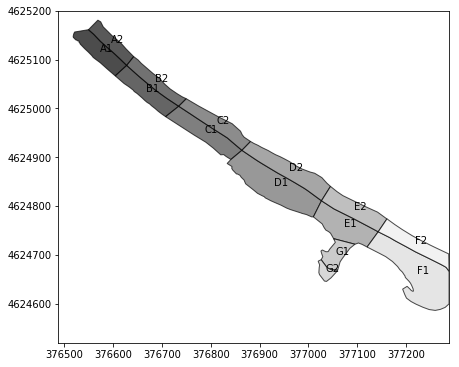

In [5]:
# plot all of the polygons
poly_names = ("A1","A2","B1","B2","C1","C2","D1","D2","E1","E2","G1","G2","F1","F2")

plt.figure(figsize=(7,7))
ax = plt.axes()
ax.set_aspect('equal')
# use bbox (bounding box) to set plot limits
plt.xlim(X[0][0],X[0][-1])
plt.ylim(Y[-1][0],Y[0][0])
with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        # print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        #print(np.shape(a))
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        poly = Polygon(tuple(map(tuple,a)))
        xc=poly.centroid.x
        yc=poly.centroid.y
        print("Area of polygon: {} {:.1f} m^2".format(poly_names[i],poly.area))
        fc = np.array([1.,1.,1.])*i/14.
        patch = PolygonPatch(poly, facecolor=fc, edgecolor=[0,0,0], alpha=0.7, zorder=2)
        ax.add_patch(patch)
        plt.text(xc,yc,poly_names[i])
        i=i+1

In [6]:
# array for calulating areas
ones = np.ones((ysize,xsize))
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))

# arrays for areas
poly_areas = np.nan*np.ones(num_poly)
mask_areas = np.nan*np.ones(num_poly)

# arrays for polygon centroids
xc = np.nan*np.ones((num_poly))
yc = np.nan*np.ones((num_poly))

with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        #print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        poly = Polygon(tuple(map(tuple,a)))
        xc[i]=poly.centroid.x
        yc[i]=poly.centroid.y
        poly_areas[i]=poly.area
        
        # raster mask
        ma[i,:,:] = shapely.vectorized.contains(poly,X,Y)
        
        # calculate area of mask
        area = np.sum(ma[i,:,:]*ones)*.1*.1
        mask_areas[i]=area
        print("{} Polygon area: {:.1f}; Mask area: {:.1f}".format(poly_names[i],poly_areas[i],mask_areas[i]))
        i = i+1


(14, 6800, 8000)
A1 Polygon area: 3851.4; Mask area: 3850.4
A2 Polygon area: 2628.6; Mask area: 2627.9
B1 Polygon area: 4112.7; Mask area: 4111.5
B2 Polygon area: 3026.3; Mask area: 3025.5
C1 Polygon area: 5095.6; Mask area: 5094.3
C2 Polygon area: 4037.0; Mask area: 4035.8
D1 Polygon area: 10104.0; Mask area: 10101.1
D2 Polygon area: 6086.1; Mask area: 6084.5
E1 Polygon area: 5773.3; Mask area: 5771.8
E2 Polygon area: 4431.7; Mask area: 4430.4
G1 Polygon area: 2228.2; Mask area: 2227.7
G2 Polygon area: 837.4; Mask area: 837.1
F1 Polygon area: 11898.5; Mask area: 11892.0
F2 Polygon area: 4168.4; Mask area: 4167.3


In [8]:
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018"]
         )
print(len(titles))

13


A1  Area:  3850.4 Volume: -11286.1 dz: -2.9 Pct. area: 100.0
A2  Area:  2627.9 Volume:  -2337.4 dz: -0.9 Pct. area: 100.0
B1  Area:  4111.5 Volume:  -8213.5 dz: -2.0 Pct. area: 100.0
B2  Area:  3025.5 Volume:  -1914.9 dz: -0.6 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -7642.7 dz: -1.5 Pct. area: 100.0
C2  Area:  4035.8 Volume:  -1855.6 dz: -0.5 Pct. area: 100.0
D1  Area: 10101.1 Volume:   2577.6 dz:  0.3 Pct. area: 100.0
D2  Area:  6084.5 Volume:    202.8 dz:  0.0 Pct. area: 100.0
E1  Area:  5771.8 Volume:  -1295.7 dz: -0.2 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -322.2 dz: -0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:   -255.7 dz: -0.1 Pct. area: 100.0
G2  Area:   837.1 Volume:   1007.6 dz:  1.2 Pct. area: 100.0
F1  Area: 11892.0 Volume:  -2412.2 dz: -0.2 Pct. area: 100.0
F2  Area:  4167.3 Volume:  -1101.8 dz: -0.3 Pct. area: 100.0
All Area: 68257.2 Volume: -34850.0 dz: -0.5 


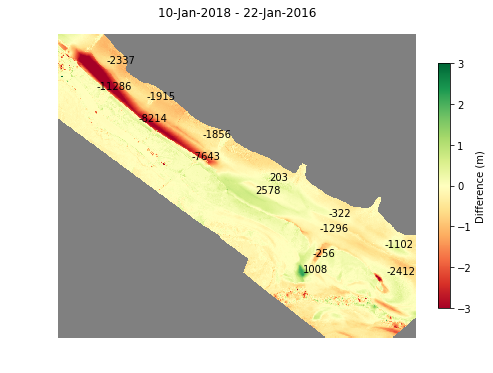

In [9]:
# make a dataframe to hold the results
df = pd.DataFrame(columns=poly_names,index=("Poly areas","Mask areas"))
df.loc["Poly areas"]=poly_areas
df.loc["Mask areas"]=mask_areas
df.round(1)

# calculate total volume change between last and first maps
dz = zw[-1,:,:]-zw[0,:,:]
has_data = np.ones((ysize,xsize))
has_data[np.isnan(dz)]=0.
#plt.imshow(has_data)

pv = np.nan*np.ones((num_poly))
pa = np.nan*np.ones((num_poly))
tot_area = 0.
tot_vol = 0.

for i in range(num_poly):
    pdz = ma[i,:,:]*dz
    pdz[np.isnan(pdz)]=0.
    pa[i] = np.sum(ma[i,:,:]*has_data)*.1*.1
    pv[i] = np.sum(pdz)*.1*.1
    tot_area = tot_area+pa[i]
    tot_vol = tot_vol+pv[i]
    print("{:3s} Area: {:7.1f} Volume: {:8.1f} dz: {:4.1f} Pct. area: {:.1f}".\
          format(poly_names[i],pa[i],pv[i],pv[i]/pa[i],100.*pa[i]/mask_areas[i]))
    
print("All Area: {:7.1f} Volume: {:8.1f} dz: {:4.1f} ".format(tot_area,tot_vol,tot_vol/tot_area))

tname = titles[-1]+" - "+titles[0]
fname = titles[-1]+"_minus_"+titles[0]+".png"
yoff = (-40.,0.,-30.,0.,-30.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)
fig=plt.figure(figsize=(8,6))
ax.set_aspect('equal')
cmap=plt.cm.RdYlGn
cmap.set_bad('grey')
plt.pcolormesh(X[0:-1:10],Y[0:-1:10],dz[0:-1:10],shading='flat',edgecolor=None,cmap=cmap,vmin=-3,vmax=3)
plt.axis('equal')
plt.xmin = X[0][0]
plt.xmax = X[0],[-1]
plt.ymin = Y[-1][0]
plt.ymax = Y[0][0]
plt.axis('off')
plt.title(tname)
cbar=plt.colorbar(shrink=0.75)
cbar.set_label('Difference (m)')
for i in range(num_poly):
    nstr = "{:.0f}".format(pv[i])
    plt.text(xc[i],yc[i]+yoff[i],nstr)

plt.show()
fig.savefig(fname,dpi=200)  

25-Jan-2016 - 22-Jan-2016
A1  Area:  3850.4 Volume:  -1714.7 dz: -0.4 Pct. area: 100.0
A2  Area:  2627.9 Volume:  -1207.2 dz: -0.5 Pct. area: 100.0
B1  Area:  4111.5 Volume:  -2077.9 dz: -0.5 Pct. area: 100.0
B2  Area:  3025.5 Volume:  -1044.2 dz: -0.3 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -2007.5 dz: -0.4 Pct. area: 100.0
C2  Area:  4035.8 Volume:  -1434.5 dz: -0.4 Pct. area: 100.0
D1  Area: 10101.1 Volume:    457.0 dz:  0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:   -135.6 dz: -0.0 Pct. area: 100.0
E1  Area:  5771.8 Volume:   -125.0 dz: -0.0 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -216.7 dz: -0.0 Pct. area: 100.0
G1  Area:  2227.7 Volume:    127.2 dz:  0.1 Pct. area: 100.0
G2  Area:   837.1 Volume:     35.5 dz:  0.0 Pct. area: 100.0
F1  Area: 11892.0 Volume:   -934.7 dz: -0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -174.7 dz: -0.0 Pct. area: 100.0


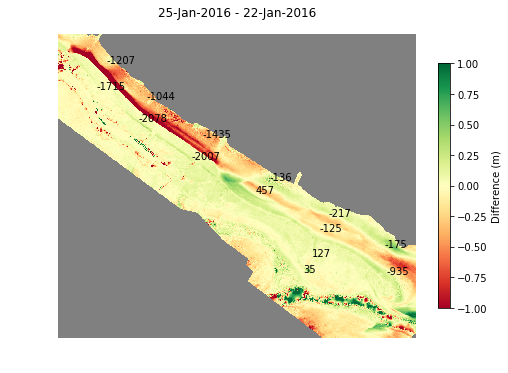

11-Feb-2016 - 25-Jan-2016
A1  Area:  3850.4 Volume:  -3299.4 dz: -0.9 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -661.1 dz: -0.3 Pct. area: 100.0
B1  Area:  4111.5 Volume:  -2286.7 dz: -0.6 Pct. area: 100.0
B2  Area:  3025.5 Volume:   -706.6 dz: -0.2 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -1692.3 dz: -0.3 Pct. area: 100.0
C2  Area:  4035.8 Volume:   -230.7 dz: -0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:   -144.8 dz: -0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:   -615.0 dz: -0.1 Pct. area: 100.0
E1  Area:  5771.8 Volume:   -593.7 dz: -0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -196.7 dz: -0.0 Pct. area: 100.0
G1  Area:  2227.7 Volume:    121.6 dz:  0.1 Pct. area: 100.0
G2  Area:   837.1 Volume:     72.3 dz:  0.1 Pct. area: 100.0
F1  Area: 11892.0 Volume:  -2295.1 dz: -0.2 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -167.5 dz: -0.0 Pct. area: 100.0


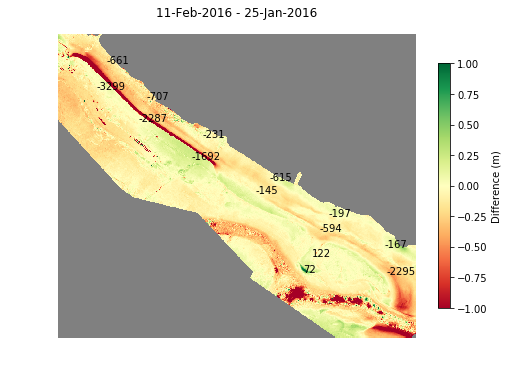

30-Mar-2016 - 11-Feb-2016
A1  Area:  3850.4 Volume:   -918.4 dz: -0.2 Pct. area: 100.0
A2  Area:  2627.9 Volume:    931.3 dz:  0.4 Pct. area: 100.0
B1  Area:  4111.5 Volume:   -835.7 dz: -0.2 Pct. area: 100.0
B2  Area:  3025.5 Volume:   1740.1 dz:  0.6 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -1300.6 dz: -0.3 Pct. area: 100.0
C2  Area:  4035.8 Volume:    880.2 dz:  0.2 Pct. area: 100.0
D1  Area: 10101.1 Volume:    770.5 dz:  0.1 Pct. area: 100.0
D2  Area:  6084.5 Volume:   1394.2 dz:  0.2 Pct. area: 100.0
E1  Area:  5771.8 Volume:    680.1 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:    636.4 dz:  0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:    -27.3 dz: -0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:    -55.0 dz: -0.1 Pct. area: 100.0
F1  Area: 11892.0 Volume:   1511.8 dz:  0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:    -44.3 dz: -0.0 Pct. area: 100.0


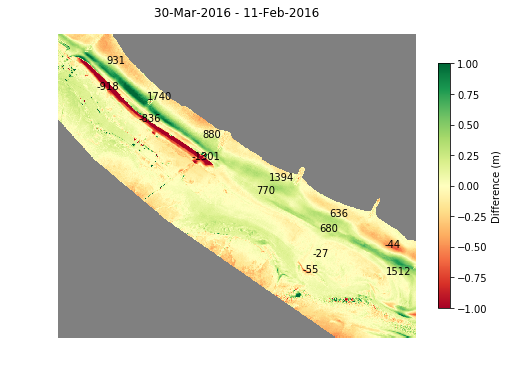

21-Sep-2016 - 30-Mar-2016
A1  Area:  3850.4 Volume:   -454.8 dz: -0.1 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -560.1 dz: -0.2 Pct. area: 100.0
B1  Area:  4111.5 Volume:    203.6 dz:  0.0 Pct. area: 100.0
B2  Area:  3025.5 Volume:   -274.8 dz: -0.1 Pct. area: 100.0
C1  Area:  5094.3 Volume:    -50.5 dz: -0.0 Pct. area: 100.0
C2  Area:  4035.8 Volume:    225.1 dz:  0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:    629.7 dz:  0.1 Pct. area: 100.0
D2  Area:  6084.5 Volume:    -57.8 dz: -0.0 Pct. area: 100.0
E1  Area:  5771.8 Volume:    412.8 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -409.9 dz: -0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:    -63.5 dz: -0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:   -107.5 dz: -0.1 Pct. area: 100.0
F1  Area: 11892.0 Volume:    998.1 dz:  0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:  -1022.6 dz: -0.2 Pct. area: 100.0


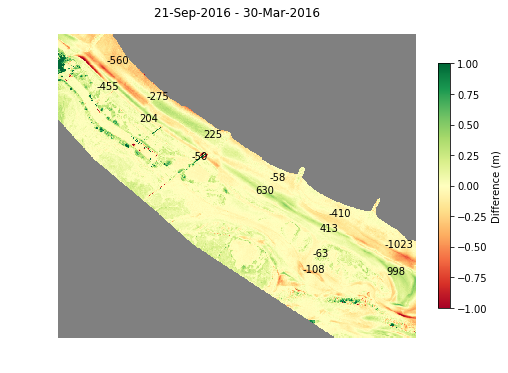

09-Jan-2017 - 21-Sep-2016
A1  Area:  3850.4 Volume:     50.6 dz:  0.0 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -824.7 dz: -0.3 Pct. area: 100.0
B1  Area:  4111.5 Volume:    217.3 dz:  0.1 Pct. area: 100.0
B2  Area:  3025.5 Volume:  -1238.8 dz: -0.4 Pct. area: 100.0
C1  Area:  5094.3 Volume:    884.5 dz:  0.2 Pct. area: 100.0
C2  Area:  4035.8 Volume:  -1089.9 dz: -0.3 Pct. area: 100.0
D1  Area: 10101.1 Volume:   1580.7 dz:  0.2 Pct. area: 100.0
D2  Area:  6084.5 Volume:   -281.9 dz: -0.0 Pct. area: 100.0
E1  Area:  5771.8 Volume:    681.5 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:    304.6 dz:  0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:     80.5 dz:  0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:    -43.0 dz: -0.1 Pct. area: 100.0
F1  Area: 11892.0 Volume:   2580.3 dz:  0.2 Pct. area: 100.0
F2  Area:  4167.3 Volume:    439.7 dz:  0.1 Pct. area: 100.0


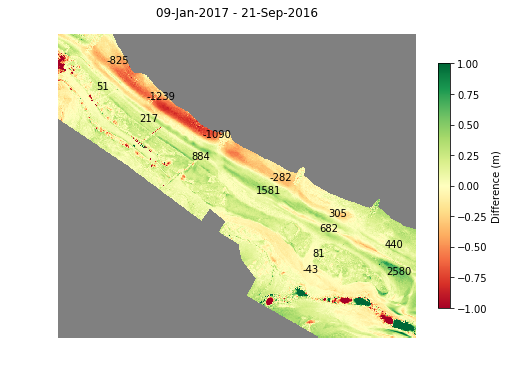

25-Jan-2017 - 09-Jan-2017
A1  Area:  3850.4 Volume:   -365.9 dz: -0.1 Pct. area: 100.0
A2  Area:  2627.9 Volume:    288.6 dz:  0.1 Pct. area: 100.0
B1  Area:  4111.5 Volume:   -559.4 dz: -0.1 Pct. area: 100.0
B2  Area:  3025.5 Volume:    181.9 dz:  0.1 Pct. area: 100.0
C1  Area:  5094.3 Volume:   -840.8 dz: -0.2 Pct. area: 100.0
C2  Area:  4035.8 Volume:   -269.7 dz: -0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:   -348.3 dz: -0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:    920.6 dz:  0.2 Pct. area: 100.0
E1  Area:  5771.8 Volume:   -419.9 dz: -0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -520.6 dz: -0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:   -138.6 dz: -0.1 Pct. area: 100.0
G2  Area:   837.1 Volume:    -53.6 dz: -0.1 Pct. area: 100.0
F1  Area: 11892.0 Volume:  -2502.4 dz: -0.2 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -794.5 dz: -0.2 Pct. area: 100.0


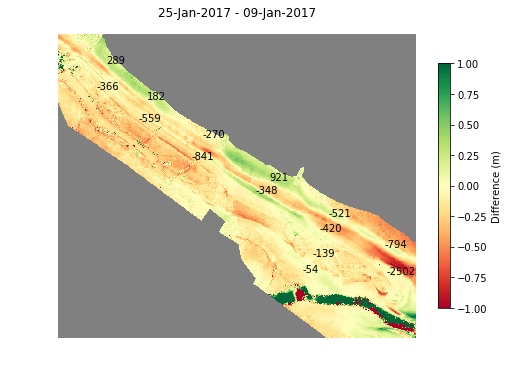

14-Feb-2017 - 25-Jan-2017
A1  Area:  3850.4 Volume:  -1918.0 dz: -0.5 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -326.2 dz: -0.1 Pct. area: 100.0
B1  Area:  4111.5 Volume:  -1345.9 dz: -0.3 Pct. area: 100.0
B2  Area:  3025.5 Volume:   -622.0 dz: -0.2 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -1392.9 dz: -0.3 Pct. area: 100.0
C2  Area:  4035.8 Volume:   -458.9 dz: -0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:   -142.4 dz: -0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:   -850.4 dz: -0.1 Pct. area: 100.0
E1  Area:  5771.8 Volume:   -407.3 dz: -0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:    -14.3 dz: -0.0 Pct. area: 100.0
G1  Area:  2227.7 Volume:     19.1 dz:  0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:    126.3 dz:  0.2 Pct. area: 100.0
F1  Area: 11892.0 Volume:    134.4 dz:  0.0 Pct. area: 100.0
F2  Area:  4167.3 Volume:    435.1 dz:  0.1 Pct. area: 100.0


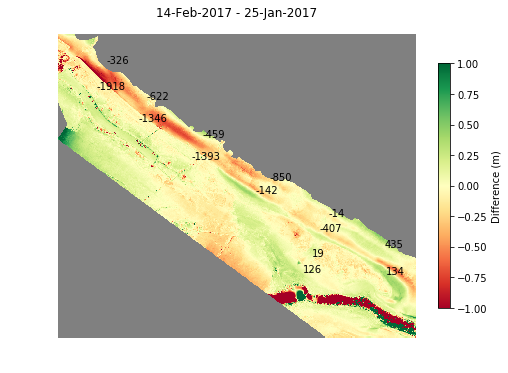

16-Mar-2017 - 14-Feb-2017
A1  Area:  3850.4 Volume:   -112.9 dz: -0.0 Pct. area: 100.0
A2  Area:  2627.9 Volume:    341.3 dz:  0.1 Pct. area: 100.0
B1  Area:  4111.5 Volume:     75.8 dz:  0.0 Pct. area: 100.0
B2  Area:  3025.5 Volume:    207.7 dz:  0.1 Pct. area: 100.0
C1  Area:  5094.3 Volume:    254.8 dz:  0.1 Pct. area: 100.0
C2  Area:  4035.8 Volume:    362.0 dz:  0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:    313.2 dz:  0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:   1203.6 dz:  0.2 Pct. area: 100.0
E1  Area:  5771.8 Volume:    510.5 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:    344.8 dz:  0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:    -30.7 dz: -0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:    -32.9 dz: -0.0 Pct. area: 100.0
F1  Area: 11892.0 Volume:   1166.1 dz:  0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -204.6 dz: -0.0 Pct. area: 100.0


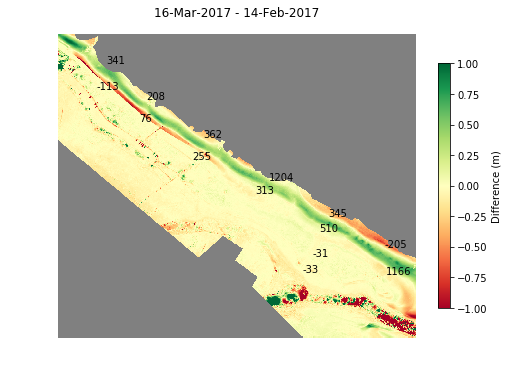

28-Apr-2017 - 16-Mar-2017
A1  Area:  3850.4 Volume:   -285.5 dz: -0.1 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -115.3 dz: -0.0 Pct. area: 100.0
B1  Area:  4111.5 Volume:     -8.0 dz: -0.0 Pct. area: 100.0
B2  Area:  3025.5 Volume:    394.8 dz:  0.1 Pct. area: 100.0
C1  Area:  5094.3 Volume:    530.3 dz:  0.1 Pct. area: 100.0
C2  Area:  4035.8 Volume:   -412.5 dz: -0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:    494.5 dz:  0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:  -1758.5 dz: -0.3 Pct. area: 100.0
E1  Area:  5771.8 Volume:    337.2 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -998.8 dz: -0.2 Pct. area: 100.0
G1  Area:  2227.7 Volume:    -27.8 dz: -0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:    -29.7 dz: -0.0 Pct. area: 100.0
F1  Area: 11892.0 Volume:    625.8 dz:  0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -781.8 dz: -0.2 Pct. area: 100.0


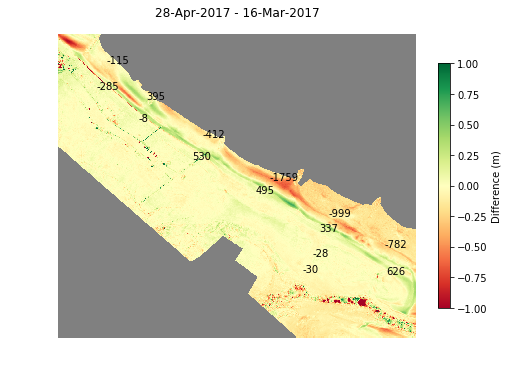

04-May_2017 - 28-Apr-2017
A1  Area:  3850.4 Volume:    -15.9 dz: -0.0 Pct. area: 100.0
A2  Area:  2627.9 Volume:     55.5 dz:  0.0 Pct. area: 100.0
B1  Area:  4111.5 Volume:     -5.7 dz: -0.0 Pct. area: 100.0
B2  Area:  3025.5 Volume:    -21.9 dz: -0.0 Pct. area: 100.0
C1  Area:  5094.3 Volume:    -58.3 dz: -0.0 Pct. area: 100.0
C2  Area:  4035.8 Volume:    -67.1 dz: -0.0 Pct. area: 100.0
D1  Area: 10101.1 Volume:   -195.5 dz: -0.0 Pct. area: 100.0
D2  Area:  6084.5 Volume:    117.0 dz:  0.0 Pct. area: 100.0
E1  Area:  5771.8 Volume:    -24.3 dz: -0.0 Pct. area: 100.0
E2  Area:  4430.4 Volume:    114.1 dz:  0.0 Pct. area: 100.0
G1  Area:  2227.7 Volume:      9.3 dz:  0.0 Pct. area: 100.0
G2  Area:   837.1 Volume:     34.3 dz:  0.0 Pct. area: 100.0
F1  Area: 11892.0 Volume:    425.8 dz:  0.0 Pct. area: 100.0
F2  Area:  4167.3 Volume:    311.1 dz:  0.1 Pct. area: 100.0


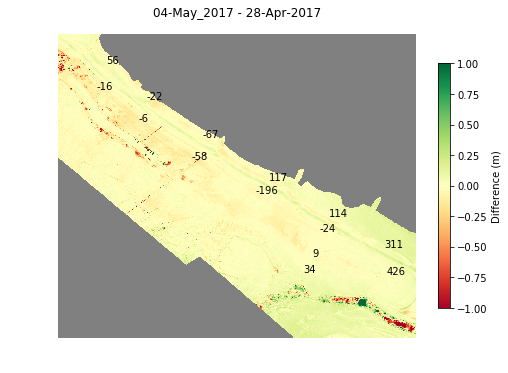

18-Sep-2017 - 04-May_2017
A1  Area:  3850.4 Volume:   1351.9 dz:  0.4 Pct. area: 100.0
A2  Area:  2627.9 Volume:   -476.2 dz: -0.2 Pct. area: 100.0
B1  Area:  4111.5 Volume:   1119.5 dz:  0.3 Pct. area: 100.0
B2  Area:  3025.5 Volume:   -626.0 dz: -0.2 Pct. area: 100.0
C1  Area:  5094.3 Volume:    594.1 dz:  0.1 Pct. area: 100.0
C2  Area:  4035.8 Volume:   -571.7 dz: -0.1 Pct. area: 100.0
D1  Area: 10101.1 Volume:    850.2 dz:  0.1 Pct. area: 100.0
D2  Area:  6084.5 Volume:  -1056.6 dz: -0.2 Pct. area: 100.0
E1  Area:  5771.8 Volume:    839.2 dz:  0.1 Pct. area: 100.0
E2  Area:  4430.4 Volume:   -543.5 dz: -0.1 Pct. area: 100.0
G1  Area:  2227.7 Volume:    112.0 dz:  0.1 Pct. area: 100.0
G2  Area:   837.1 Volume:    -25.1 dz: -0.0 Pct. area: 100.0
F1  Area: 11892.0 Volume:   1187.3 dz:  0.1 Pct. area: 100.0
F2  Area:  4167.3 Volume:   -410.7 dz: -0.1 Pct. area: 100.0


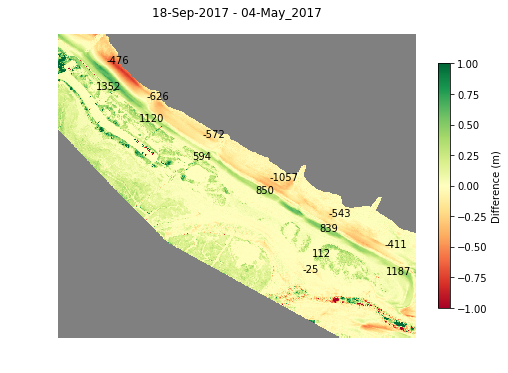

10-Jan-2018 - 18-Sep-2017
A1  Area:  3850.4 Volume:  -3602.9 dz: -0.9 Pct. area: 100.0
A2  Area:  2627.9 Volume:    172.0 dz:  0.1 Pct. area: 100.0
B1  Area:  4111.5 Volume:  -2710.7 dz: -0.7 Pct. area: 100.0
B2  Area:  3025.5 Volume:    138.5 dz:  0.0 Pct. area: 100.0
C1  Area:  5094.3 Volume:  -2563.5 dz: -0.5 Pct. area: 100.0
C2  Area:  4035.8 Volume:   1230.8 dz:  0.3 Pct. area: 100.0
D1  Area: 10101.1 Volume:  -1687.2 dz: -0.2 Pct. area: 100.0
D2  Area:  6084.5 Volume:   1648.2 dz:  0.3 Pct. area: 100.0
E1  Area:  5771.8 Volume:  -3186.6 dz: -0.6 Pct. area: 100.0
E2  Area:  4430.4 Volume:   1182.7 dz:  0.3 Pct. area: 100.0
G1  Area:  2227.7 Volume:   -437.5 dz: -0.2 Pct. area: 100.0
G2  Area:   837.1 Volume:   1086.1 dz:  1.3 Pct. area: 100.0
F1  Area: 11892.0 Volume:  -5309.6 dz: -0.4 Pct. area: 100.0
F2  Area:  4167.3 Volume:   1342.9 dz:  0.3 Pct. area: 100.0


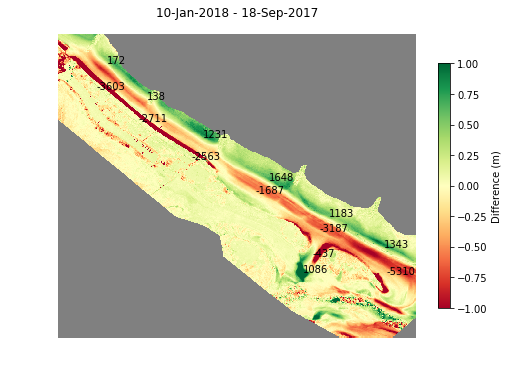

In [16]:
# calculate array of differences and plot difference maps
zdiff = np.zeros((num_maps-1,ysize,xsize))
zd = np.zeros((ysize,xsize))
for i in range(num_maps-1):
    zd = zw[i+1][:][:]-zw[i][:][:]
    zdiff[i][:][:]=zd


has_data = np.ones((ysize,xsize))
has_data[np.isnan(dz)]=0.
#plt.imshow(has_data)

pv = np.nan*np.ones((num_poly,num_maps-1))
pa = np.nan*np.ones((num_poly,num_maps-1))
tot_area = np.zeros((num_maps-1))
tot_vol = np.zeros((num_maps-1))

for j in range(num_maps-1):
    tname = titles[j+1]+" - "+titles[j]
    fname = titles[j+1]+"_minus_"+titles[j]+".png"
    print(tname)
    zd = np.squeeze(zdiff[j,:,:])
    for i in range(num_poly):
        pdz = ma[i,:,:]*zd
        pdz[np.isnan(pdz)]=0.
        pa[i,j] = np.sum(ma[i,:,:]*has_data)*.1*.1
        pv[i,j] = np.sum(pdz)*.1*.1
        tot_area[j] = tot_area[j]+pa[i,j]
        tot_vol[j] = tot_vol[j]+pv[i,j]
        print("{:3s} Area: {:7.1f} Volume: {:8.1f} dz: {:4.1f} Pct. area: {:.1f}".\
            format(poly_names[i],pa[i,j],pv[i,j],pv[i,j]/pa[i,j],100.*pa[i,j]/mask_areas[i]))
        
    # plotting
    yoff = (-40.,0.,-30.,0.,-30.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)
    fig=plt.figure(figsize=(8,6))
    ax.set_aspect('equal')
    cmap=plt.cm.RdYlGn
    cmap.set_bad('grey')
    plt.pcolormesh(X[0:-1:10],Y[0:-1:10],zd[0:-1:10],shading='flat',edgecolor=None,cmap=cmap,vmin=-1,vmax=1)
    plt.axis('equal')
    plt.xmin = X[0][0]
    plt.xmax = X[0],[-1]
    plt.ymin = Y[-1][0]
    plt.ymax = Y[0][0]
    plt.axis('off')
    plt.title(tname)
    cbar=plt.colorbar(shrink=0.75)
    cbar.set_label('Difference (m)')
    for i in range(num_poly):
        nstr = "{:.0f}".format(pv[i,j])
        plt.text(xc[i],yc[i]+yoff[i],nstr)

    plt.show()
    fig.savefig(fname,dpi=200)  
        